In [91]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import seaborn as sns
import joblib
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, silhouette_score

In [92]:
df = pd.read_csv("bank_transactions_data_2.csv")

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [94]:
cols_kept = ["TransactionDate", "TransactionType",  "Location", "Channel", "TransactionDuration", "LoginAttempts", "TransactionAmount"]
df = df[cols_kept]

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TransactionDate      2512 non-null   object 
 1   TransactionType      2512 non-null   object 
 2   Location             2512 non-null   object 
 3   Channel              2512 non-null   object 
 4   TransactionDuration  2512 non-null   int64  
 5   LoginAttempts        2512 non-null   int64  
 6   TransactionAmount    2512 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 137.5+ KB


In [96]:
for col in df:
    print(f"{col}: {df[col].nunique()} unique values")

TransactionDate: 2405 unique values
TransactionType: 2 unique values
Location: 43 unique values
Channel: 3 unique values
TransactionDuration: 288 unique values
LoginAttempts: 5 unique values
TransactionAmount: 2455 unique values


In [97]:
# Split TransactionDate into Date and Time
df[['Date', 'Time']] = df['TransactionDate'].str.split(' ', expand=True)

# Drop the original TransactionDate column
df.drop('TransactionDate', axis=1, inplace=True)

# Convert Date to datetime format (DD/MM/YYYY)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)

# Convert Time from HH:MM to total seconds since midnight
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour * 3600 + pd.to_datetime(df['Time'], format='%H:%M').dt.minute * 60

# Extract the day of the week from the Date column
df['DayOfWeek'] = df['Date'].dt.day_name()

In [98]:
# 🟢 Step 2: Encode Categorical Variables
encoder = LabelEncoder()
categorical_cols = ["Location"]
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])


In [99]:
location_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
location_mapping_json = {key: int(value) for key, value in location_mapping.items()}

In [100]:
# Save as JSON
with open("location_mapping.json", "w") as f:
    json.dump(location_mapping_json, f, indent=4)

print("Mapping saved to location_mapping.json")

Mapping saved to location_mapping.json


In [101]:
# Manually map categorical values
transaction_type_mapping = {"Debit": 0, "Credit": 1}
channel_mapping = {"ATM": 0, "Online": 1, "Branch": 2}
day_of_week_mapping = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, 
    "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
}

df["TransactionType"] = df["TransactionType"].map(transaction_type_mapping)
df["Channel"] = df["Channel"].map(channel_mapping)
df["DayOfWeek"] = df["DayOfWeek"].map(day_of_week_mapping)

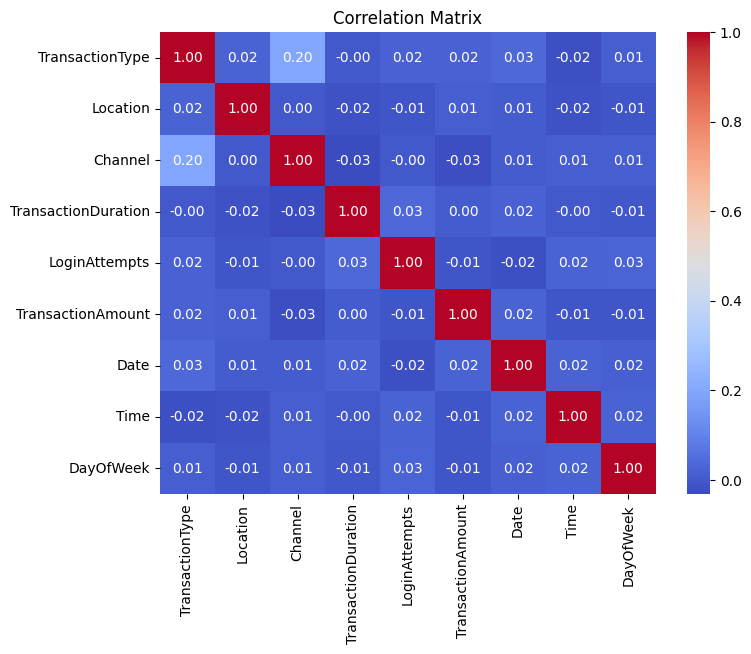

In [102]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig("correlation_matrix.png")
plt.show()

In [103]:
# Select Features for Anomaly Detection
features = ["TransactionType", "Location", "Channel", "Time", "TransactionDuration", "LoginAttempts", "DayOfWeek", "TransactionAmount"]
X = df[features]

Isolation Forests

In [104]:
# Isolation Forest Model
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df["Anomaly_IF"] = iso_forest.fit_predict(X)
df["Anomaly_IF"] = df["Anomaly_IF"].map({1: "Normal", -1: "Anomalous"})

Local Outlier Factor

In [105]:
# Local Outlier Factor Model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
lof.fit(X)
df["Anomaly_LOF"] = lof.fit_predict(X)
df["Anomaly_LOF"] = df["Anomaly_LOF"].map({1: "Normal", -1: "Anomalous"})

In [106]:
# Compute threshold for anomaly detection
lof_scores = -lof.negative_outlier_factor_
lof_threshold = np.percentile(lof_scores, 98)  # Adjust percentile based on contamination level


In [107]:
joblib.dump(lof_threshold, "lof_threshold.pkl")

['lof_threshold.pkl']

OneClass SVM

In [108]:
# OneClass SVM Model
oc_svm = OneClassSVM(nu=0.02, kernel="rbf", gamma='auto')
df["Anomaly_OCSVM"] = oc_svm.fit_predict(X)
df["Anomaly_OCSVM"] = df["Anomaly_OCSVM"].map({1: "Normal", -1: "Anomalous"})

In [109]:

# Save the trained models
joblib.dump(iso_forest, "isolation_forest_model.pkl")
joblib.dump(lof, "local_outlier_factor_model.pkl")
joblib.dump(oc_svm, "one_class_svm_model.pkl")


['one_class_svm_model.pkl']

In [110]:

# Save cleaned data
df.to_csv("cleaned_transactions.csv", index=False)

Evaluation Metrics

In [111]:
# Define models
model_names = ["Anomaly_IF", "Anomaly_LOF", "Anomaly_OCSVM"]
silhouette_scores = {}

In [112]:
for model_name in model_names:
    # Count anomalies vs normal
    anomaly_counts = df[model_name].value_counts()

    # Create a bar chart
    plt.figure(figsize=(6, 4))
    sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="coolwarm")
    plt.title(f"Anomaly Counts for {model_name}")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.savefig(f"{model_name}_counts.png")
    plt.close()

    print(f"Saved: {model_name}_counts.png")

    # Compute Silhouette Score
    labels = df[model_name].map({"Normal": 1, "Anomalous": -1}).values
    silhouette = silhouette_score(X, labels)
    silhouette_scores[model_name] = silhouette

C:\Users\Cristopher Artacho\AppData\Local\Temp\ipykernel_28464\1127789825.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="coolwarm")


Saved: Anomaly_IF_counts.png


C:\Users\Cristopher Artacho\AppData\Local\Temp\ipykernel_28464\1127789825.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="coolwarm")


Saved: Anomaly_LOF_counts.png
Saved: Anomaly_OCSVM_counts.png


C:\Users\Cristopher Artacho\AppData\Local\Temp\ipykernel_28464\1127789825.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="coolwarm")


In [113]:
# Plot Silhouette Scores
plt.figure(figsize=(6, 4))
sns.barplot(x=list(silhouette_scores.keys()), y=list(silhouette_scores.values()), palette="viridis")
plt.title("Silhouette Scores Comparison")
plt.xlabel("Model")
plt.ylabel("Silhouette Score")
plt.savefig("silhouette_scores.png")
plt.close()

print("Saved: silhouette_scores.png")

Saved: silhouette_scores.png


C:\Users\Cristopher Artacho\AppData\Local\Temp\ipykernel_28464\2923815808.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(silhouette_scores.keys()), y=list(silhouette_scores.values()), palette="viridis")


In [114]:
# # Evaluation Metrics
# for model_name in ["Anomaly_IF", "Anomaly_LOF", "Anomaly_OCSVM"]:
#     anomaly_counts = df[model_name].value_counts()
#     print(f"Anomaly counts for {model_name}:\n", anomaly_counts)

#     labels = df[model_name].map({"Normal": 1, "Anomalous": -1}).values
#     silhouette = silhouette_score(X, labels)
#     print(f"Silhouette Score for {model_name}: {silhouette:.4f}\n")


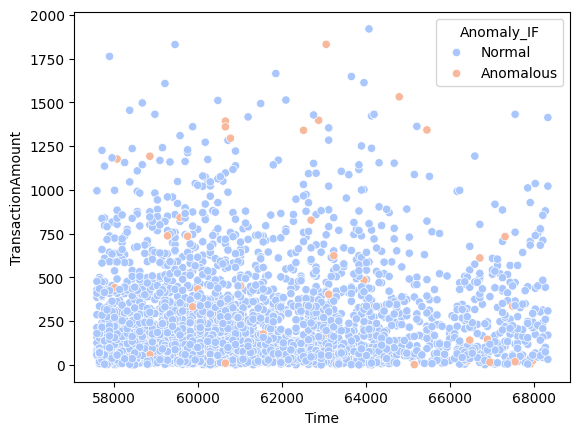

In [115]:
# Visualization
sns.scatterplot(x=df["Time"], y=df["TransactionAmount"], hue=df["Anomaly_IF"], palette="coolwarm")
plt.show()


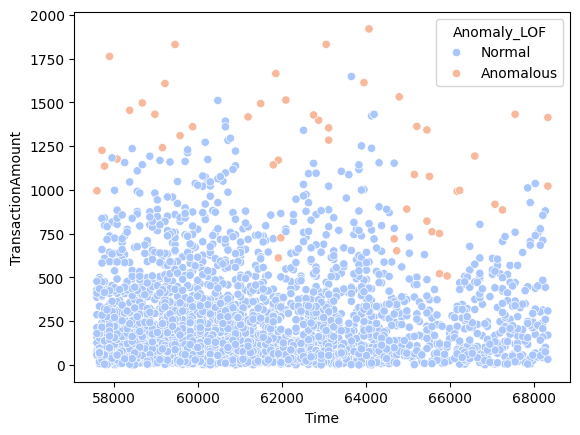

In [116]:
sns.scatterplot(x=df["Time"], y=df["TransactionAmount"], hue=df["Anomaly_LOF"], palette="coolwarm")
plt.show()

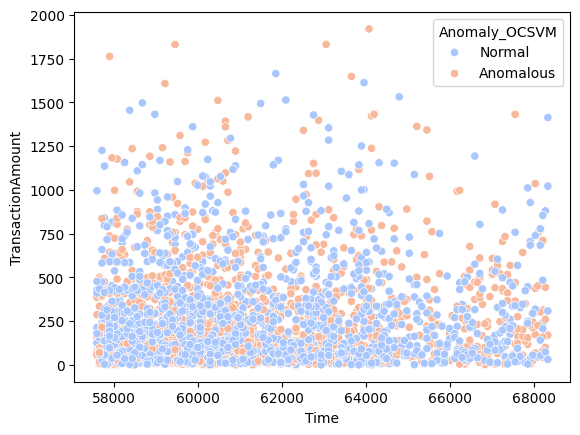

In [117]:
sns.scatterplot(x=df["Time"], y=df["TransactionAmount"], hue=df["Anomaly_OCSVM"], palette="coolwarm")
plt.show()
